# Big Processing Data

#### Importation of Required Libraries
We're importing the following libraries for the project: Pyspark, Matplotlib, Seaborn, ...

Note: I am using Pycharm environment, so the environment is setup and doesn't need installation, but I'll also provide the code for install the libraries needed to run the project as well.

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count
from sklearn.metrics import confusion_matrix
from pyspark.sql.functions import expr, sum
import numpy as np
import pandas as pd
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StringIndexer
from pyspark.sql.functions import sum
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator


#### Initialize Spark Session


In [2]:
# Initialize Spark Session
spark = SparkSession.builder.appName("DataMerge").getOrCreate()

# Verify Spark session creation by performing a simple operation
try:
    # Try creating a simple DataFrame and show it
    test_df = spark.range(2)  # Create a DataFrame with numbers 0 to 9
    test_df.show()  # Display the DataFrame
    print("Spark session is working and operational!")
except Exception as e:
    print(f"Error while verifying Spark session: {e}")

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/01/12 01:18:33 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/01/12 01:18:46 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


+---+
| id|
+---+
|  0|
|  1|
+---+

Spark session is working and operational!


### Loading the Datasets
This section will focus on loading the following datasets: <b>DimProduct.csv, FactInternetSales.csv, DimCustomer.csv, DimProductCategory.csv, DimProductSubCategory.csv, DimDate.csv, DimSalesTerritory.csv, </b> for our processing and analysis.

In [3]:
# File paths
files = {
    "DimProduct": "Dataset/DimProduct.csv",
    "FactInternetSales": "Dataset/FactInternetSales.csv",
    "DimCustomer": "Dataset/DimCustomer.csv",
    "DimProductCategory": "Dataset/DimProductCategory.csv",
    "DimProductSubcategory": "Dataset/DimProductSubcategory.csv",
    "DimSalesTerritory": "Dataset/DimSalesTerritory.csv",
    "DimDate": "Dataset/DimDate.csv",
}

# Load datasets
datasets = {name: spark.read.csv(path, header=True, inferSchema=True) for name, path in files.items()}

### Display Schema
Checking the structure of each schema by verifying column names and data types to spot unexpected inconsistencies

In [4]:
# Displaying the schema for all datasets
for name, df in datasets.items():
    print(f"Schema for {name}:")
    df.printSchema()
    print("\n" + "="*50 + "\n")


Schema for DimProduct:
root
 |-- ProductKey: integer (nullable = true)
 |-- ProductAlternateKey: string (nullable = true)
 |-- ProductSubcategoryKey: integer (nullable = true)
 |-- WeightUnitMeasureCode: string (nullable = true)
 |-- SizeUnitMeasureCode: string (nullable = true)
 |-- EnglishProductName: string (nullable = true)
 |-- SpanishProductName: string (nullable = true)
 |-- FrenchProductName: string (nullable = true)
 |-- StandardCost: double (nullable = true)
 |-- FinishedGoodsFlag: boolean (nullable = true)
 |-- Color: string (nullable = true)
 |-- SafetyStockLevel: integer (nullable = true)
 |-- ReorderPoint: integer (nullable = true)
 |-- ListPrice: double (nullable = true)
 |-- Size: string (nullable = true)
 |-- SizeRange: string (nullable = true)
 |-- Weight: double (nullable = true)
 |-- DaysToManufacture: integer (nullable = true)
 |-- ProductLine: string (nullable = true)
 |-- DealerPrice: double (nullable = true)
 |-- Class: string (nullable = true)
 |-- Style: strin

#### Standardizing Column Names to Snake Case

In [5]:
# Function to convert column names to snake_case
def standardize_column_names(df):
    for col_name in df.columns:
        new_col_name = col_name[0].lower() + "".join(["_" + c.lower() if c.isupper() else c for c in col_name[1:]])
        df = df.withColumnRenamed(col_name, new_col_name)
    return df

# Apply column renaming to all datasets
datasets = {name: standardize_column_names(df) for name, df in datasets.items()}

# Verify column name updates
for name, df in datasets.items():
    print(f"Updated columns in {name}: {df.columns}")


Updated columns in DimProduct: ['product_key', 'product_alternate_key', 'product_subcategory_key', 'weight_unit_measure_code', 'size_unit_measure_code', 'english_product_name', 'spanish_product_name', 'french_product_name', 'standard_cost', 'finished_goods_flag', 'color', 'safety_stock_level', 'reorder_point', 'list_price', 'size', 'size_range', 'weight', 'days_to_manufacture', 'product_line', 'dealer_price', 'class', 'style', 'model_name', 'english_description', 'start_date', 'end_date', 'status']
Updated columns in FactInternetSales: ['product_key', 'order_date_key', 'due_date_key', 'ship_date_key', 'customer_key', 'promotion_key', 'currency_key', 'sales_territory_key', 'sales_order_number', 'sales_order_line_number', 'revision_number', 'order_quantity', 'unit_price', 'extended_amount', 'unit_price_discount_pct', 'discount_amount', 'product_standard_cost', 'total_product_cost', 'sales_amount', 'tax_amt', 'freight', 'carrier_tracking_number', 'customer_p_o_number', 'order_date', 'due_

#### Checking to see if there's Key Column Names Match in Datasets

In [6]:
key_columns = {
    "FactInternetSales": ["product_key", "customer_key", "order_date_key", "sales_territory_key"],
    "DimProduct": ["product_key", "product_subcategory_key"],
    "DimProductSubcategory": ["product_subcategory_key", "product_category_key"],
    "DimProductCategory": ["product_category_key"],
    "DimCustomer": ["customer_key"],
    "DimSalesTerritory": ["sales_territory_key"],
    "DimDate": ["date_key"]
}

# Print key column names for verification
for dataset, keys in key_columns.items():
    print(f"Checking keys in {dataset}:")
    for key in keys:
        if key in datasets[dataset].columns:
            print(f"{key} exists in {dataset}")
        else:
            print(f"{key} is MISSING in {dataset}!")
    print("\n" + "="*50 + "\n")


Checking keys in FactInternetSales:
product_key exists in FactInternetSales
customer_key exists in FactInternetSales
order_date_key exists in FactInternetSales
sales_territory_key exists in FactInternetSales


Checking keys in DimProduct:
product_key exists in DimProduct
product_subcategory_key exists in DimProduct


Checking keys in DimProductSubcategory:
product_subcategory_key exists in DimProductSubcategory
product_category_key exists in DimProductSubcategory


Checking keys in DimProductCategory:
product_category_key exists in DimProductCategory


Checking keys in DimCustomer:
customer_key exists in DimCustomer


Checking keys in DimSalesTerritory:
sales_territory_key exists in DimSalesTerritory


Checking keys in DimDate:
date_key exists in DimDate




#### Checking to see if Key Columns have the same data type

In [7]:
# Check data types of key columns in each dataset
for dataset, keys in key_columns.items():
    print(f"Checking data types in {dataset}:")
    datasets[dataset].select(keys).printSchema()
    print("\n" + "="*50 + "\n")


Checking data types in FactInternetSales:
root
 |-- product_key: integer (nullable = true)
 |-- customer_key: integer (nullable = true)
 |-- order_date_key: integer (nullable = true)
 |-- sales_territory_key: integer (nullable = true)



Checking data types in DimProduct:
root
 |-- product_key: integer (nullable = true)
 |-- product_subcategory_key: integer (nullable = true)



Checking data types in DimProductSubcategory:
root
 |-- product_subcategory_key: integer (nullable = true)
 |-- product_category_key: integer (nullable = true)



Checking data types in DimProductCategory:
root
 |-- product_category_key: integer (nullable = true)



Checking data types in DimCustomer:
root
 |-- customer_key: integer (nullable = true)



Checking data types in DimSalesTerritory:
root
 |-- sales_territory_key: integer (nullable = true)



Checking data types in DimDate:
root
 |-- date_key: integer (nullable = true)





#### Checking for Null values in key columns

In [8]:
# Check for NULL values in key columns
for dataset, keys in key_columns.items():
    print(f"Checking for NULL values in {dataset}:")
    for key in keys:
        null_count = datasets[dataset].filter(col(key).isNull()).count()
        print(f"{key} has {null_count} NULL values in {dataset}")
    print("\n" + "="*50 + "\n")


Checking for NULL values in FactInternetSales:


product_key has 0 NULL values in FactInternetSales


customer_key has 0 NULL values in FactInternetSales
order_date_key has 0 NULL values in FactInternetSales
sales_territory_key has 0 NULL values in FactInternetSales


Checking for NULL values in DimProduct:
product_key has 0 NULL values in DimProduct
product_subcategory_key has 0 NULL values in DimProduct


Checking for NULL values in DimProductSubcategory:
product_subcategory_key has 0 NULL values in DimProductSubcategory
product_category_key has 0 NULL values in DimProductSubcategory


Checking for NULL values in DimProductCategory:
product_category_key has 0 NULL values in DimProductCategory


Checking for NULL values in DimCustomer:
customer_key has 0 NULL values in DimCustomer


Checking for NULL values in DimSalesTerritory:
sales_territory_key has 0 NULL values in DimSalesTerritory


Checking for NULL values in DimDate:
date_key has 0 NULL values in DimDate




### Joining the Our Datasets

In [9]:
# Start with the fact table
fact_sales = datasets["FactInternetSales"]

# Join FactInternetSales with DimProduct
fact_sales = fact_sales.join(datasets["DimProduct"], "product_key", "left")

# Join FactInternetSales with DimCustomer
fact_sales = fact_sales.join(datasets["DimCustomer"], "customer_key", "left")

# Join FactInternetSales with DimDate
fact_sales = fact_sales.join(datasets["DimDate"], fact_sales.order_date_key == datasets["DimDate"].date_key, "left").drop("date_key")

# Join FactInternetSales with DimSalesTerritory
fact_sales = fact_sales.join(datasets["DimSalesTerritory"], "sales_territory_key", "left")

# Join DimProduct with DimProductSubcategory
dim_product = datasets["DimProduct"].join(datasets["DimProductSubcategory"], "product_subcategory_key", "left")

# Join DimProductSubcategory with DimProductCategory
dim_product = dim_product.join(datasets["DimProductCategory"], "product_category_key", "left")

# Display final merged fact_sales dataset
fact_sales.show(10)


25/01/12 01:19:12 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------------------+------------+-----------+--------------+------------+-------------+-------------+------------+------------------+-----------------------+---------------+--------------+----------+---------------+-----------------------+---------------+---------------------+------------------+------------+--------+-------+-----------------------+-------------------+-------------------+-------------------+-------------------+---------------------+-----------------------+------------------------+----------------------+--------------------+--------------------+--------------------+-------------+-------------------+------+------------------+-------------+----------+----+----------+------+-------------------+------------+------------+-----+-----+------------+--------------------+----------------+----------------+------+-------------+----------------------+-----+----------+-----------+---------+----------+----------+--------------+------+------+--------------------+-------------+---------

## Data quality checks and data cleaning process

#### Checking row count check before and after joining

In [10]:
# Check row count before and after joining
fact_sales_count = datasets["FactInternetSales"].count()
merged_fact_sales_count = fact_sales.count()

print(f"FactInternetSales before join: {fact_sales_count} rows")
print(f"Merged dataset after join: {merged_fact_sales_count} rows")


FactInternetSales before join: 60398 rows
Merged dataset after join: 60398 rows


#### Check for duplicate rows

In [11]:
# Check for duplicate rows
duplicate_count = fact_sales.groupBy(fact_sales.columns).count().filter("count > 1").count()
print(f"Duplicate rows in merged dataset: {duplicate_count}")

Duplicate rows in merged dataset: 0


#### Check for NULL Values in Important Columns

In [12]:

# List of important columns to check
important_columns = ["product_key", "customer_key", "order_date_key", "sales_territory_key", "sales_amount"]

# Check for NULL values in important columns
for col_name in important_columns:
    null_count = fact_sales.filter(col(col_name).isNull()).count()
    print(f"{col_name} has {null_count} NULL values")

product_key has 0 NULL values
customer_key has 0 NULL values
order_date_key has 0 NULL values
sales_territory_key has 0 NULL values
sales_amount has 0 NULL values


#### Check for Duplicate Rows

In [13]:
fact_sales.select("order_quantity", "unit_price", "sales_amount", "tax_amt", "freight").describe().show()

+-------+--------------+-----------------+-----------------+-----------------+------------------+
|summary|order_quantity|       unit_price|     sales_amount|          tax_amt|           freight|
+-------+--------------+-----------------+-----------------+-----------------+------------------+
|  count|         60398|            60398|            60398|            60398|             60398|
|   mean|           1.0|486.0869105053777|486.0869105053777|38.88695370873952|12.152217111493709|
| stddev|           0.0| 928.489891980807| 928.489891980807|74.27919255248155|23.212248232767838|
|    min|             1|             2.29|             2.29|           0.1832|            0.0573|
|    max|             1|          3578.27|          3578.27|         286.2616|           89.4568|
+-------+--------------+-----------------+-----------------+-----------------+------------------+



## Business Questions

#### Sales and Product Analysis<br>
1. Which products generate the highest sales revenue and profit margins?
2. How do sales trends vary across different sales territories?
3. How does product performance vary across different categories and subcategories?

##### Which products generate the highest sales revenue and profit margins?


In [14]:
#Which products generate the highest sales revenue and profit margins?
#
product_analysis = fact_sales.groupBy("english_product_name") \
    .agg(
        sum("sales_amount").alias("total_sales"),
        sum(expr("sales_amount - total_product_cost")).alias("profit_margin")
    ) \
    .orderBy("total_sales", ascending=False)

product_analysis.show(10)

+--------------------+------------------+------------------+
|english_product_name|       total_sales|     profit_margin|
+--------------------+------------------+------------------+
|Mountain-200 Blac...|1373469.5481999982| 626621.5735000019|
|Mountain-200 Blac...| 1363142.093399998| 621759.6083000018|
|Mountain-200 Silv...| 1339462.790399998| 610864.4347999995|
|Mountain-200 Silv...|1301100.0983999984| 593490.4727999989|
|Mountain-200 Blac...| 1294866.141199998| 590477.4604000015|
|Mountain-200 Silv...| 1257434.572799998| 573511.9375999994|
|    Road-150 Red, 48|1205876.9900000044|474150.84460000356|
|    Road-150 Red, 62|1202298.7200000044|472743.86880000355|
|    Road-150 Red, 52|1080637.5400000038|424906.69160000305|
|    Road-150 Red, 56|1055589.6500000036|415057.86100000294|
+--------------------+------------------+------------------+
only showing top 10 rows



In [15]:
fact_sales.printSchema()

root
 |-- sales_territory_key: integer (nullable = true)
 |-- customer_key: integer (nullable = true)
 |-- product_key: integer (nullable = true)
 |-- order_date_key: integer (nullable = true)
 |-- due_date_key: integer (nullable = true)
 |-- ship_date_key: integer (nullable = true)
 |-- promotion_key: integer (nullable = true)
 |-- currency_key: integer (nullable = true)
 |-- sales_order_number: string (nullable = true)
 |-- sales_order_line_number: integer (nullable = true)
 |-- revision_number: integer (nullable = true)
 |-- order_quantity: integer (nullable = true)
 |-- unit_price: double (nullable = true)
 |-- extended_amount: double (nullable = true)
 |-- unit_price_discount_pct: integer (nullable = true)
 |-- discount_amount: integer (nullable = true)
 |-- product_standard_cost: double (nullable = true)
 |-- total_product_cost: double (nullable = true)
 |-- sales_amount: double (nullable = true)
 |-- tax_amt: double (nullable = true)
 |-- freight: double (nullable = true)
 |-- c

In [16]:
# Check if english_product_category_name exists in the dataset
fact_sales.columns


['sales_territory_key',
 'customer_key',
 'product_key',
 'order_date_key',
 'due_date_key',
 'ship_date_key',
 'promotion_key',
 'currency_key',
 'sales_order_number',
 'sales_order_line_number',
 'revision_number',
 'order_quantity',
 'unit_price',
 'extended_amount',
 'unit_price_discount_pct',
 'discount_amount',
 'product_standard_cost',
 'total_product_cost',
 'sales_amount',
 'tax_amt',
 'freight',
 'carrier_tracking_number',
 'customer_p_o_number',
 'order_date',
 'due_date',
 'ship_date',
 'product_alternate_key',
 'product_subcategory_key',
 'weight_unit_measure_code',
 'size_unit_measure_code',
 'english_product_name',
 'spanish_product_name',
 'french_product_name',
 'standard_cost',
 'finished_goods_flag',
 'color',
 'safety_stock_level',
 'reorder_point',
 'list_price',
 'size',
 'size_range',
 'weight',
 'days_to_manufacture',
 'product_line',
 'dealer_price',
 'class',
 'style',
 'model_name',
 'english_description',
 'start_date',
 'end_date',
 'status',
 'geography_ke

In [17]:
# Join FactInternetSales with DimProduct
fact_sales_with_product = fact_sales.join(
    datasets["DimProduct"], "product_key", "inner"
)

# Join with DimProductSubcategory
fact_sales_with_subcategory = fact_sales_with_product.join(
    datasets["DimProductSubcategory"], "product_subcategory_key", "inner"
)

# Join with DimProductCategory to get the category name
fact_sales_with_category = fact_sales_with_subcategory.join(
    datasets["DimProductCategory"], "product_category_key", "inner"
)

# Perform category-level sales and profit analysis
category_analysis = fact_sales_with_category.groupBy("english_product_category_name") \
    .agg(
        sum("sales_amount").alias("total_sales"),
        sum(expr("sales_amount - total_product_cost")).alias("profit_margin")
    ) \
    .orderBy("total_sales", ascending=False)

category_analysis.show()


+-----------------------------+--------------------+--------------------+
|english_product_category_name|         total_sales|       profit_margin|
+-----------------------------+--------------------+--------------------+
|                        Bikes|2.8318144650701128E7|1.1505796500600025E7|
|                  Accessories|   700759.9599999422|  438674.56809997605|
|                     Clothing|   339772.6100000149|  136412.57629999678|
+-----------------------------+--------------------+--------------------+



/var/folders/vq/2z3hvmh94k13pb_1b0fmr7wm0000gn/T/ipykernel_10740/3720069064.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="total_sales", y="english_product_name", data=product_sales_df, palette="Blues_r")


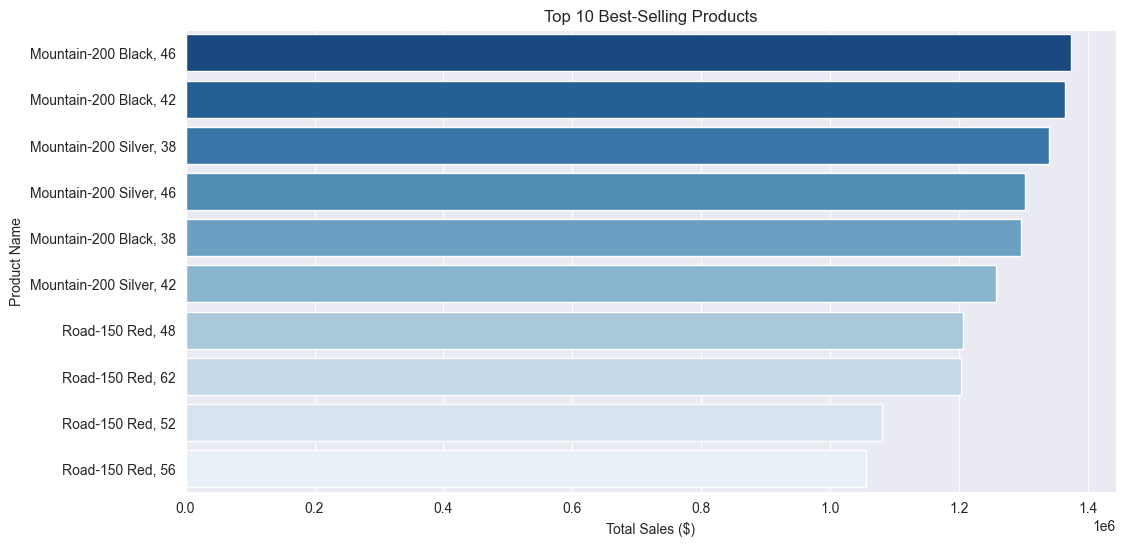

In [18]:
#Top-Selling Products (Bar Chart)
# Convert to Pandas
product_sales_df = product_analysis.limit(10).toPandas()

# Plot Top-Selling Products
plt.figure(figsize=(12, 6))
sns.barplot(x="total_sales", y="english_product_name", data=product_sales_df, palette="Blues_r")
plt.xlabel("Total Sales ($)")
plt.ylabel("Product Name")
plt.title("Top 10 Best-Selling Products")
plt.show()

In [19]:
print(category_analysis.columns)


['english_product_category_name', 'total_sales', 'profit_margin']


/var/folders/vq/2z3hvmh94k13pb_1b0fmr7wm0000gn/T/ipykernel_10740/1897914809.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="profit_per_unit", y="english_product_name", data=profit_per_unit_df, palette="coolwarm")


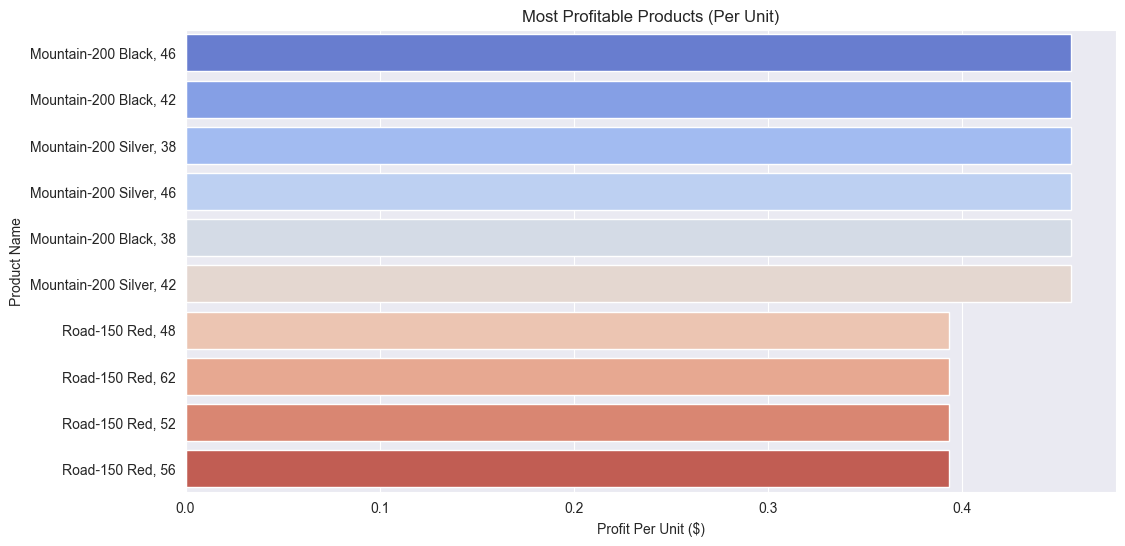

In [20]:
#Profit Margins by Product Category (Bar Chart)
# Compute Profit Per Unit
product_analysis = product_analysis.withColumn("profit_per_unit", expr("profit_margin / total_sales"))

# Convert to Pandas for Visualization
profit_per_unit_df = product_analysis.limit(10).toPandas()

# Plot Profit Per Unit for Top Products
plt.figure(figsize=(12, 6))
sns.barplot(x="profit_per_unit", y="english_product_name", data=profit_per_unit_df, palette="coolwarm")
plt.xlabel("Profit Per Unit ($)")
plt.ylabel("Product Name")
plt.title("Most Profitable Products (Per Unit)")
plt.show()


##### How do sales trends vary across different sales territories?



In [21]:
#2️⃣ Analyze Sales by Territory

territory_sales = fact_sales.groupBy("sales_territory_group") \
    .agg(sum("sales_amount").alias("total_sales")) \
    .orderBy("total_sales", ascending=False)

territory_sales.show()

+---------------------+--------------------+
|sales_territory_group|         total_sales|
+---------------------+--------------------+
|        North America|1.1367634372902095E7|
|              Pacific|   9061000.584400563|
|               Europe|   8930042.263400966|
+---------------------+--------------------+



###### Sales Distribution Across Territories

/var/folders/vq/2z3hvmh94k13pb_1b0fmr7wm0000gn/T/ipykernel_10740/2696049287.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="total_sales", y="sales_territory_group", data=territory_sales_df, palette="coolwarm")


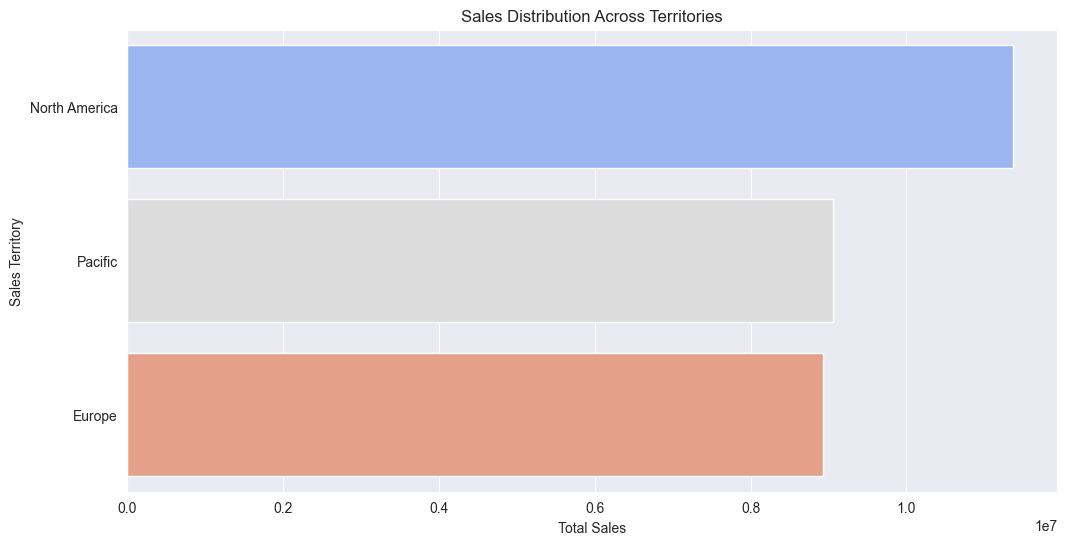

In [22]:
#Sales Distribution Across Territories

# Aggregate sales by sales territory
territory_sales = fact_sales.groupBy("sales_territory_group") \
    .agg(sum("sales_amount").alias("total_sales")) \
    .orderBy("total_sales", ascending=False)

# Convert to Pandas for visualization
territory_sales_df = territory_sales.toPandas()

# Plot Sales by Territory
plt.figure(figsize=(12, 6))
sns.barplot(x="total_sales", y="sales_territory_group", data=territory_sales_df, palette="coolwarm")
plt.xlabel("Total Sales")
plt.ylabel("Sales Territory")
plt.title("Sales Distribution Across Territories")
plt.show()



##### How does product performance vary across different categories and subcategories?

In [23]:

# Aggregate total sales by product category and subcategory
category_sales = fact_sales_with_category.groupBy("english_product_category_name", "english_product_subcategory_name") \
    .agg(sum("sales_amount").alias("total_sales")) \
    .orderBy("total_sales", ascending=False)

category_sales.show(10)


+-----------------------------+--------------------------------+--------------------+
|english_product_category_name|english_product_subcategory_name|         total_sales|
+-----------------------------+--------------------------------+--------------------+
|                        Bikes|                      Road Bikes|1.4520584036299847E7|
|                        Bikes|                  Mountain Bikes|   9952759.564400222|
|                        Bikes|                   Touring Bikes|  3844801.0500000035|
|                  Accessories|                 Tires and Tubes|  245529.32000000443|
|                  Accessories|                         Helmets|  225335.60000000076|
|                     Clothing|                         Jerseys|  172950.67999999886|
|                     Clothing|                          Shorts|   71319.81000000038|
|                  Accessories|               Bottles and Cages|    56798.1900000005|
|                  Accessories|                       

/var/folders/vq/2z3hvmh94k13pb_1b0fmr7wm0000gn/T/ipykernel_10740/2632519124.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="total_sales", y="english_product_category_name", data=category_sales_df, palette="viridis")


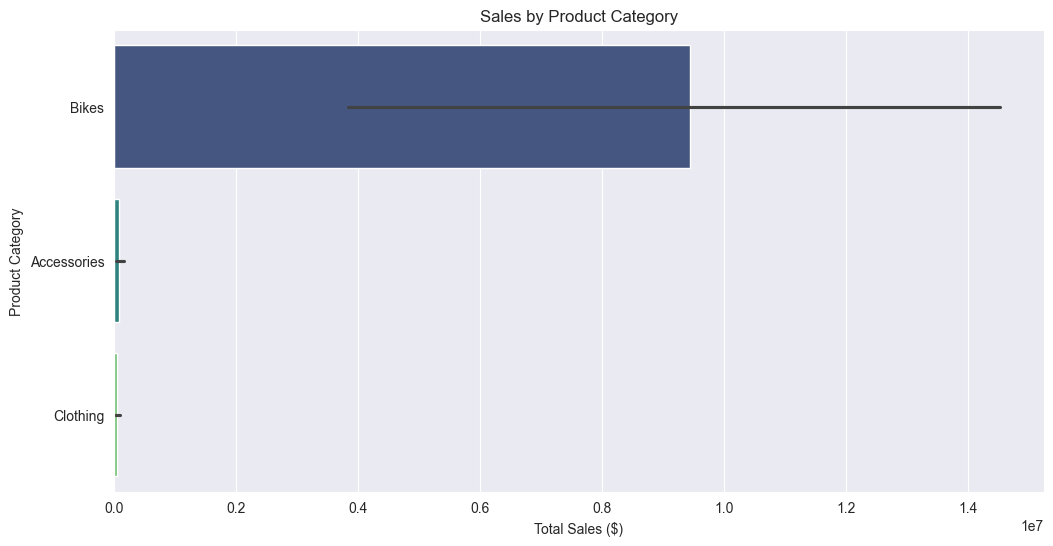

/var/folders/vq/2z3hvmh94k13pb_1b0fmr7wm0000gn/T/ipykernel_10740/2632519124.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="total_sales", y="english_product_subcategory_name", data=category_sales_df, palette="coolwarm")


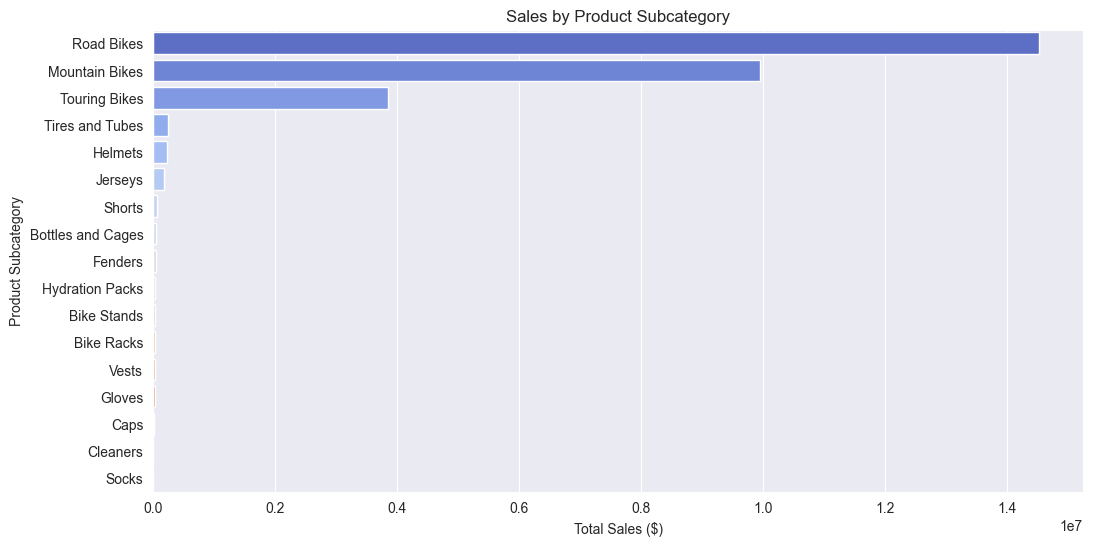

In [24]:
# Convert to Pandas
category_sales_df = category_sales.toPandas()

# Plot Sales by Product Category
plt.figure(figsize=(12, 6))
sns.barplot(x="total_sales", y="english_product_category_name", data=category_sales_df, palette="viridis")
plt.xlabel("Total Sales ($)")
plt.ylabel("Product Category")
plt.title("Sales by Product Category")
plt.show()

# Plot Sales by Subcategory
plt.figure(figsize=(12, 6))
sns.barplot(x="total_sales", y="english_product_subcategory_name", data=category_sales_df, palette="coolwarm")
plt.xlabel("Total Sales ($)")
plt.ylabel("Product Subcategory")
plt.title("Sales by Product Subcategory")
plt.show()

# Machine Learning Predictions

### Predicting Product Categories for Future Purchases (Classification)


In [25]:
# Join with category data
product_category_data = fact_sales.join(
    datasets["DimProduct"].join(
        datasets["DimProductSubcategory"],
        "product_subcategory_key"
    ).join(
        datasets["DimProductCategory"],
        "product_category_key"
    ),
    "product_key"
).select(
    "customer_key",
    "sales_territory_group",
    "english_product_category_name",
    "sales_amount"
)

product_category_data.show()


+------------+---------------------+-----------------------------+------------+
|customer_key|sales_territory_group|english_product_category_name|sales_amount|
+------------+---------------------+-----------------------------+------------+
|       25086|        North America|                     Clothing|       24.49|
|       19225|        North America|                     Clothing|        63.5|
|       23105|              Pacific|                     Clothing|       24.49|
|       16944|               Europe|                     Clothing|       24.49|
|       29356|               Europe|                     Clothing|        63.5|
|       28207|              Pacific|                     Clothing|        63.5|
|       22432|               Europe|                     Clothing|       24.49|
|       21349|        North America|                     Clothing|       24.49|
|       21017|               Europe|                     Clothing|       24.49|
|       11088|        North America|    

In [26]:
#2️⃣ Predict Product Categories for Future Purchases
from pyspark.sql.functions import col

# Join fact_sales with product dimensions
labeled_data = fact_sales_with_category.select(
    "customer_key",
    "sales_territory_group",
    "order_quantity",
    "sales_amount",
    "freight",
    "english_product_category_name"  # Target variable
)

labeled_data.show(10)


+------------+---------------------+--------------+------------+-------+-----------------------------+
|customer_key|sales_territory_group|order_quantity|sales_amount|freight|english_product_category_name|
+------------+---------------------+--------------+------------+-------+-----------------------------+
|       21768|        North America|             1|     3578.27|89.4568|                        Bikes|
|       28389|               Europe|             1|     3399.99|84.9998|                        Bikes|
|       25863|        North America|             1|     3399.99|84.9998|                        Bikes|
|       14501|        North America|             1|    699.0982|17.4775|                        Bikes|
|       11003|              Pacific|             1|     3399.99|84.9998|                        Bikes|
|       27645|        North America|             1|     3578.27|89.4568|                        Bikes|
|       16624|              Pacific|             1|     3578.27|89.4568| 

In [27]:
print(labeled_data.columns)


['customer_key', 'sales_territory_group', 'order_quantity', 'sales_amount', 'freight', 'english_product_category_name']


In [28]:

# Convert category name to numerical labels
indexer = StringIndexer(inputCol="english_product_category_name", outputCol="label")
labeled_data = indexer.fit(labeled_data).transform(labeled_data)

# Verify if label column exists now
print(labeled_data.columns)
labeled_data.select("english_product_category_name", "label").show(5)


['customer_key', 'sales_territory_group', 'order_quantity', 'sales_amount', 'freight', 'english_product_category_name', 'label']
+-----------------------------+-----+
|english_product_category_name|label|
+-----------------------------+-----+
|                        Bikes|  1.0|
|                        Bikes|  1.0|
|                        Bikes|  1.0|
|                        Bikes|  1.0|
|                        Bikes|  1.0|
+-----------------------------+-----+
only showing top 5 rows



In [29]:

feature_cols = ["order_quantity", "sales_amount", "freight"]
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
labeled_data = assembler.transform(labeled_data)

# Verify the features column
labeled_data.select("features", "label").show(5, truncate=False)


+----------------------+-----+
|features              |label|
+----------------------+-----+
|[1.0,3578.27,89.4568] |1.0  |
|[1.0,3399.99,84.9998] |1.0  |
|[1.0,3399.99,84.9998] |1.0  |
|[1.0,699.0982,17.4775]|1.0  |
|[1.0,3399.99,84.9998] |1.0  |
+----------------------+-----+
only showing top 5 rows



In [30]:
# Train-Test Split
train_data, test_data = labeled_data.randomSplit([0.8, 0.2], seed=42)


In [31]:

# Train a Random Forest model
rf = RandomForestClassifier(featuresCol="features", labelCol="label", numTrees=100)
rf_model = rf.fit(train_data)

# Make predictions
predictions = rf_model.transform(test_data)

# Evaluate the model
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print(f"Accuracy: {accuracy}")


Accuracy: 0.9478696741854636


In [32]:
#Evaluate Precision, Recall, and F1-Score

In [33]:
# Compute precision, recall, and F1-score
evaluator_f1 = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")
evaluator_precision = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedPrecision")
evaluator_recall = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedRecall")


In [34]:
f1_score = evaluator_f1.evaluate(predictions)
precision = evaluator_precision.evaluate(predictions)
recall = evaluator_recall.evaluate(predictions)

print(f"F1-Score: {f1_score}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")

F1-Score: 0.9481818288439081
Precision: 0.9485808847352818
Recall: 0.9478696741854636


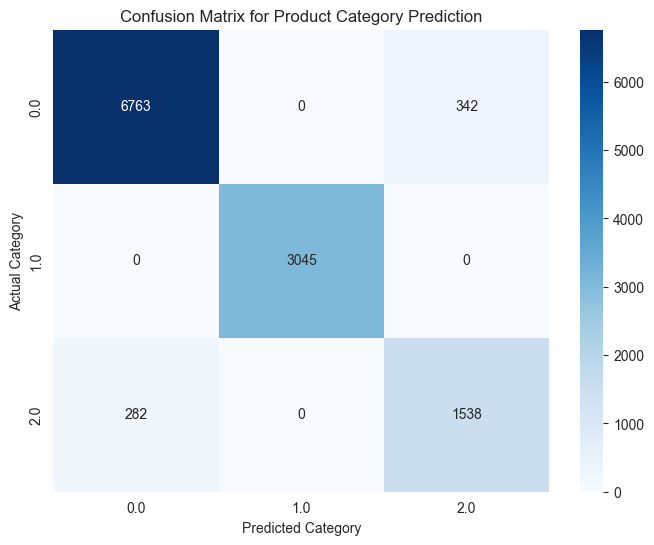

In [35]:
#Confusion Matrix for Model Performance

# Convert Spark Predictions to Pandas
predictions_pd = predictions.select("label", "prediction").toPandas()

# Generate Confusion Matrix
conf_matrix = confusion_matrix(predictions_pd["label"], predictions_pd["prediction"])

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=sorted(predictions_pd["label"].unique()), yticklabels=sorted(predictions_pd["label"].unique()))
plt.xlabel("Predicted Category")
plt.ylabel("Actual Category")
plt.title("Confusion Matrix for Product Category Prediction")
plt.show()


#### Feature Importance Analysis
Random Forest models provide feature importance scores. You can use them to understand which factors (e.g., order_quantity, sales_amount, freight) are most influential in predicting product categories.

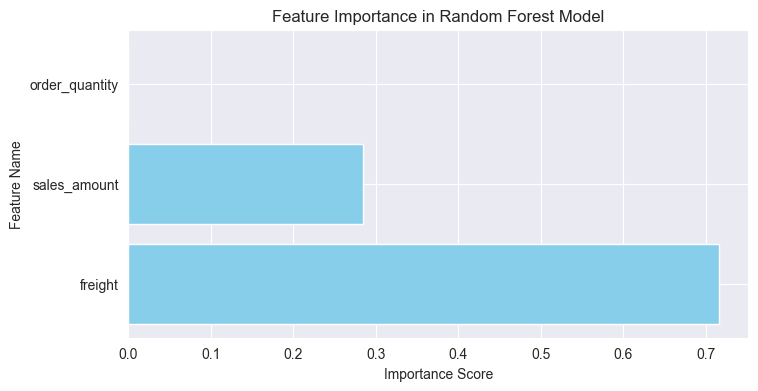

In [36]:
# Extract feature importance

feature_importances = rf_model.featureImportances.toArray()
feature_names = ["order_quantity", "sales_amount", "freight"]

# Convert to DataFrame for visualization
importance_df = pd.DataFrame({"Feature": feature_names, "Importance": feature_importances})
importance_df = importance_df.sort_values(by="Importance", ascending=False)

# Plot feature importance
plt.figure(figsize=(8, 4))
plt.barh(importance_df["Feature"], importance_df["Importance"], color="skyblue")
plt.xlabel("Importance Score")
plt.ylabel("Feature Name")
plt.title("Feature Importance in Random Forest Model")
plt.show()


#### Hyperparameter Tuning (Model Optimization)

In [37]:

# Define model
rf = RandomForestClassifier(featuresCol="features", labelCol="label")

# Create hyperparameter grid
paramGrid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [50, 100, 150]) \
    .addGrid(rf.maxDepth, [5, 10, 15]) \
    .addGrid(rf.minInstancesPerNode, [1, 5, 10]) \
    .build()

In [38]:
# Define cross-validation
crossval = CrossValidator(
    estimator=rf,
    estimatorParamMaps=paramGrid,
    evaluator=MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy"),
    numFolds=3
)


In [39]:

# Fit the model
cv_model = crossval.fit(train_data)

In [40]:
# Make predictions
cv_predictions = cv_model.transform(test_data)

# Evaluate accuracy after tuning
cv_accuracy = evaluator.evaluate(cv_predictions)
print(f"Tuned Model Accuracy: {cv_accuracy}")

Tuned Model Accuracy: 0.9714285714285714


In [41]:
# from pyspark.ml.evaluation import MulticlassClassificationEvaluator

precision_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedPrecision")
recall_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedRecall")
f1_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")

precision = precision_evaluator.evaluate(cv_predictions)
recall = recall_evaluator.evaluate(cv_predictions)
f1_score = f1_evaluator.evaluate(cv_predictions)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1_score}")


Precision: 0.9759481961147086
Recall: 0.9714285714285714
F1 Score: 0.9723032199845948


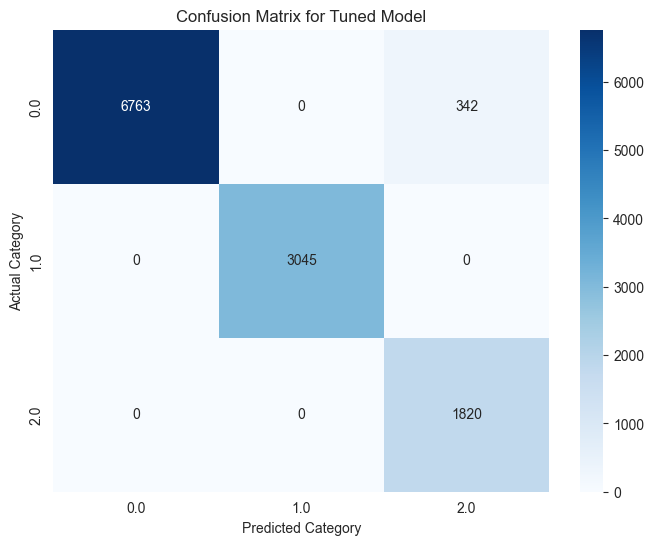

In [42]:
# Generate the confusion matrix
confusion_matrix = cv_predictions.groupBy("label", "prediction").count().orderBy("label", "prediction")
confusion_matrix_df = confusion_matrix.toPandas()

# Pivot the DataFrame for heatmap visualization
pivot_df = confusion_matrix_df.pivot(index="label", columns="prediction", values="count").fillna(0)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(pivot_df, annot=True, fmt="g", cmap="Blues", cbar=True)
plt.xlabel("Predicted Category")
plt.ylabel("Actual Category")
plt.title("Confusion Matrix for Tuned Model")
plt.show()

In [43]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Initialize Logistic Regression
lr = LogisticRegression(featuresCol="features", labelCol="label", maxIter=100)

# Train the model
lr_model = lr.fit(train_data)

# Make predictions
lr_predictions = lr_model.transform(test_data)

# Evaluate accuracy
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
lr_accuracy = evaluator.evaluate(lr_predictions)

print(f"Logistic Regression Accuracy: {lr_accuracy:.4f}")


25/01/12 01:26:23 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
25/01/12 01:26:23 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS


Logistic Regression Accuracy: 0.8546


In [44]:
from pyspark.ml.classification import DecisionTreeClassifier

# Initialize Decision Tree Classifier
dt = DecisionTreeClassifier(featuresCol="features", labelCol="label", maxDepth=10)

# Train the model
dt_model = dt.fit(train_data)

# Make predictions
dt_predictions = dt_model.transform(test_data)

# Evaluate accuracy
dt_accuracy = evaluator.evaluate(dt_predictions)

print(f"Decision Tree Accuracy: {dt_accuracy:.4f}")


Decision Tree Accuracy: 0.9714


In [47]:
from pyspark.ml.classification import GBTClassifier, OneVsRest
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Initialize the base GBT classifier
gbt = GBTClassifier(featuresCol="features", labelCol="label", maxIter=100, maxDepth=5)

# Apply One-vs-Rest to enable multi-class classification
ovr = OneVsRest(classifier=gbt)

# Train the model
ovr_model = ovr.fit(train_data)

# Make predictions
gbt_predictions = ovr_model.transform(test_data)

# Evaluate the model
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
gbt_accuracy = evaluator.evaluate(gbt_predictions)

print(f"Gradient Boosted Trees Accuracy (One-vs-Rest): {gbt_accuracy}")

# Confusion Matrix
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.sql.functions import col

# Convert predictions to RDD format
prediction_and_labels = gbt_predictions.select(col("prediction"), col("label")).rdd.map(tuple)

# Compute Confusion Matrix
metrics = MulticlassMetrics(prediction_and_labels)
print(metrics.confusionMatrix().toArray())


25/01/12 01:33:48 WARN DAGScheduler: Broadcasting large task binary with size 1043.7 KiB


Gradient Boosted Trees Accuracy (One-vs-Rest): 0.9714285714285714


/Users/apple2015/Documents/MSc/SchoolStuff/Bigdata/coursework/project/BigDataProcessing/.venv/lib/python3.11/site-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(
25/01/12 01:33:57 WARN DAGScheduler: Broadcasting large task binary with size 1043.4 KiB
25/01/12 01:34:01 WARN DAGScheduler: Broadcasting large task binary with size 1056.7 KiB


[[6763.    0.  342.]
 [   0. 3045.    0.]
 [   0.    0. 1820.]]


In [52]:
from pyspark.ml.classification import NaiveBayes

# Define model
nb = NaiveBayes(featuresCol="features", labelCol="label")

# Train the model
nb_model = nb.fit(train_data)

# Make predictions
nb_predictions = nb_model.transform(test_data)

# Evaluate
nb_accuracy = evaluator.evaluate(nb_predictions)
print(f"Naïve Bayes Accuracy: {nb_accuracy}")


Naïve Bayes Accuracy: 0.8383458646616542


In [58]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Function to evaluate accuracy
def evaluate_model(model, train_data, test_data):
    # Predictions on training data
    train_predictions = model.transform(train_data)
    train_accuracy = evaluator.evaluate(train_predictions)

    # Predictions on test data
    test_predictions = model.transform(test_data)
    test_accuracy = evaluator.evaluate(test_predictions)

    return train_accuracy, test_accuracy

# Define the evaluator
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")

# Evaluate models
rf_train_acc, rf_test_acc = evaluate_model(rf_model, train_data, test_data)
gbt_train_acc, gbt_test_acc = evaluate_model(ovr_model, train_data, test_data)
lr_train_acc, lr_test_acc = evaluate_model(lr_model, train_data, test_data)
nb_train_acc, nb_test_acc = evaluate_model(nb_model, train_data, test_data)
dt_train_acc, dt_test_acc = evaluate_model(dt_model, train_data, test_data)

# Print results dt_model
print(f"Random Forest - Train Accuracy: {rf_train_acc}, Test Accuracy: {rf_test_acc}")
print(f"Gradient Boosted Trees - Train Accuracy: {gbt_train_acc}, Test Accuracy: {gbt_test_acc}")
print(f"Decision Tree  - Train Accuracy: {dt_train_acc}, Test Accuracy: {dt_test_acc}")
print(f"Naïve Bayes - Train Accuracy: {nb_train_acc}, Test Accuracy: {nb_test_acc}")


ConnectionRefusedError: [Errno 61] Connection refused

In [56]:
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Initialize Decision Tree Classifier
dt = DecisionTreeClassifier(featuresCol="features", labelCol="label")

# Create a hyperparameter grid
paramGrid = ParamGridBuilder() \
    .addGrid(dt.maxDepth, [5, 10, 15]) \
    .addGrid(dt.minInstancesPerNode, [1, 5, 10]) \
    .addGrid(dt.impurity, ["gini", "entropy"]) \
    .build()

# Define cross-validation
crossval = CrossValidator(
    estimator=dt,
    estimatorParamMaps=paramGrid,
    evaluator=MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy"),
    numFolds=3  # 3-Fold Cross Validation
)

# Train the model with cross-validation
cv_dt_model = crossval.fit(train_data)

# Make predictions on the test data
cv_dt_predictions = cv_dt_model.transform(test_data)

# Evaluate accuracy after tuning
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
cv_dt_accuracy = evaluator.evaluate(cv_dt_predictions)

print(f"Tuned Decision Tree Accuracy: {cv_dt_accuracy:.4f}")


Tuned Decision Tree Accuracy: 0.9714
